# Predicting Patient Satisfaction from HCAHPS Survey Data

### B. Allen
### January 2026

--------
## 1. Project Overview
The goal of this project is to predict patient satisfaction scores using publicly available HCAHPS survey data.
By building predictive models and analyzing feature importance, I aim to understand which aspects of patient experience most strongly influence overall hospital satisfaction.


**Objective:**  
Determine whether overall patient satisfaction with a hospital can be predicted using responses from the HCAHPS survey and hospital-level characteristics.

**Key Question:**  
Can we predict overall hospital satisfaction using patient experience measures and hospital attributes?

**Why this matters:**  
Understanding the drivers of patient satisfaction can help hospitals prioritize improvement efforts and enhance patient experience.


In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

sns.set(style='whitegrid')


## 2. Dataset

The dataset used in this project comes from the **Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS)** survey, publicly available through the Centers for Medicare & Medicaid Services (CMS).

- File name: `HCAHPS-Hospital.csv
- Data includes:
  - Patient experience measures
  - Hospital characteristics
  - Aggregated survey response percentages


## 3. Initial Data Inspection

An initial data inspection is done to understand:
- Dataset size
- Available features
- Data types
- Potential data quality issues


In [9]:
df = pd.read_csv('HCAHPS-Hospital.csv')

df.head()

<ipython-input-9-db68fb908f61>:1: DtypeWarning: Columns (12,14,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('HCAHPS-Hospital.csv')


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,HCAHPS Measure ID,HCAHPS Question,...,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Start Date,End Date
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_A_P,"Patients who reported that their nurses ""Alway...",...,NaN,75,NaN,Not Applicable,627,NaN,17,NaN,01/01/2024,12/31/2024
1,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_SN_P,"Patients who reported that their nurses ""Somet...",...,NaN,6,NaN,Not Applicable,627,NaN,17,NaN,01/01/2024,12/31/2024
2,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_U_P,"Patients who reported that their nurses ""Usual...",...,NaN,19,NaN,Not Applicable,627,NaN,17,NaN,01/01/2024,12/31/2024
3,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_LINEAR_SCORE,Nurse communication - linear mean score,...,NaN,Not Applicable,NaN,90,627,NaN,17,NaN,01/01/2024,12/31/2024
4,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_STAR_RATING,Nurse communication - star rating,...,NaN,Not Applicable,NaN,Not Applicable,627,NaN,17,NaN,01/01/2024,12/31/2024


In [10]:
df.shape

(445563, 22)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445563 entries, 0 to 445562
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype 
---  ------                                 --------------   ----- 
 0   Facility ID                            445563 non-null  object
 1   Facility Name                          445563 non-null  object
 2   Address                                445563 non-null  object
 3   City/Town                              445563 non-null  object
 4   State                                  445563 non-null  object
 5   ZIP Code                               445563 non-null  int64 
 6   County/Parish                          445563 non-null  object
 7   Telephone Number                       445563 non-null  object
 8   HCAHPS Measure ID                      445563 non-null  object
 9   HCAHPS Question                        445563 non-null  object
 10  HCAHPS Answer Description              445563 non-null  object
 11  

## 4. Data Wrangling

The HCAHPS dataset is provided in **long format**, meaning each row represents a single survey measure and response category for a hospital.

Key columns typically include:
- Hospital identifiers (name, CMS ID, state)
- Survey measure or question
- Response category (e.g., "Always", "9 or 10")
- Reported value (percentage)

Before modeling, the data must be reshaped into a **wide, hospital-level format**, so each row represents a single hospital.

In [14]:
def clean_hcahps_data(df):
    '''
    Cleans HCAHPS raw data: handles 'Not Available' strings, 
    converts ratings to numeric, and pivots the table.
    '''
    # Replacing CMS-specific string nulls with actual NaNs
    df = df.replace(['Not Available', 'Too Few Samples'], np.nan)
    
    # Converting Star Ratings to numeric (they often load as objects/strings)
    # Focus will be 'Patient Survey Star Rating' column
    df['Patient Survey Star Rating'] = pd.to_numeric(df['Patient Survey Star Rating'], errors='coerce')
    
    # Pivoting the data
    # This turns each unique question into its own column per hospital
    df_pivoted = df.pivot_table(
        index=['Facility ID', 'Facility Name', 'Address', 'City/Town', 'State', 'ZIP Code', 'County/Parish'],
        columns='HCAHPS Question',
        values='Patient Survey Star Rating'
    ).reset_index()
    
    # Dropping columns/rows that are entirely empty after the pivot
    df_pivoted = df_pivoted.dropna(axis=1, how='all')
    
    return df_pivoted

# Applying the function
df_clean = clean_hcahps_data(df)

# Checking the new shape: it should have significantly fewer rows but more columns
print(f"Cleaned Data Shape: {df_clean.shape}")

Cleaned Data Shape: (3166, 18)


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Facility ID                                  3166 non-null   object 
 1   Facility Name                                3166 non-null   object 
 2   Address                                      3166 non-null   object 
 3   City/Town                                    3166 non-null   object 
 4   State                                        3166 non-null   object 
 5   ZIP Code                                     3166 non-null   int64  
 6   County/Parish                                3166 non-null   object 
 7   Care transition - star rating                3166 non-null   float64
 8   Cleanliness - star rating                    3166 non-null   float64
 9   Communication about medicines - star rating  3166 non-null   float64
 10  

In [16]:
df_clean.head()

HCAHPS Question,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Care transition - star rating,Cleanliness - star rating,Communication about medicines - star rating,Discharge information - star rating,Doctor communication - star rating,Nurse communication - star rating,Overall hospital rating - star rating,Quietness - star rating,Recommend hospital - star rating,Staff responsiveness - star rating,Summary star rating
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,5.0,3.0,3.0
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,3.0,3.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0,2.0,3.0
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0
3,010011,ST. VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,3.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0
4,010012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,3.0,2.0,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0


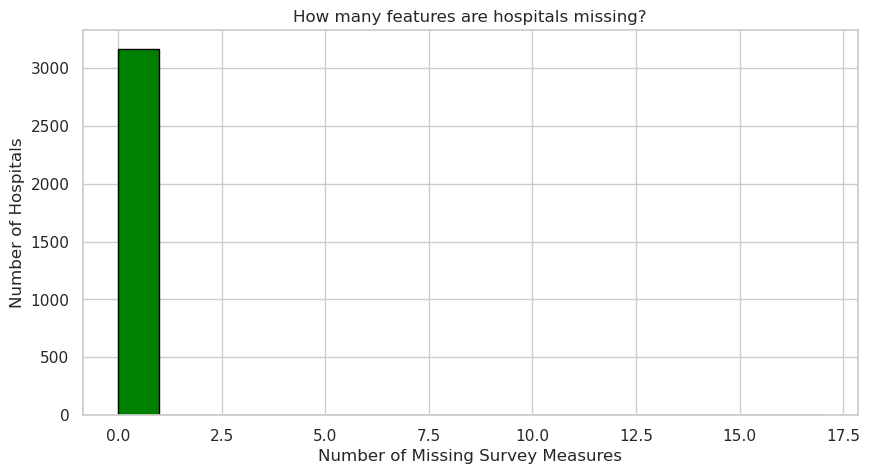

In [17]:
# Calculating missing values per hospital (row)
missing_per_hospital = df_clean.isnull().sum(axis=1)

# Plotting the distribution of missing data per row
plt.figure(figsize=(10, 5))
plt.hist(missing_per_hospital, bins=range(len(df_clean.columns)), color='green', edgecolor='black')
plt.title('How many features are hospitals missing?')
plt.xlabel('Number of Missing Survey Measures')
plt.ylabel('Number of Hospitals')
plt.show()

## 5. Target Variable

**Overall hospital rating** will be the target variable

Reasoning:
- Intuitive definition of patient satisfaction
- Commonly used in CMS reporting
- Relevant to stakeholders

*Summary star rating will be excluded to prevent data leakage.*

In [18]:
target_col='Overall hospital rating - star rating'

## 6. EDA

Key considerations:
- Distribution of overall hospital rating
- Outlier identification
- Distribution of each feature

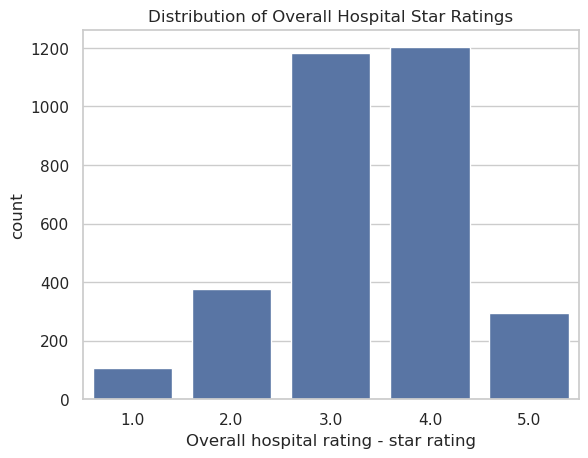

In [20]:
sns.countplot(x=df_clean[target_col])
plt.title('Distribution of Overall Hospital Star Ratings')
plt.show()

Distribution is relatively normal, with 1 star ratings and 5 star ratings being comparitavely rare. 

In [21]:
rating_cols = [
    col for col in df_clean.columns 
    if 'star rating' in col.lower()
]

df_clean[rating_cols].describe()

HCAHPS Question,Care transition - star rating,Cleanliness - star rating,Communication about medicines - star rating,Discharge information - star rating,Doctor communication - star rating,Nurse communication - star rating,Overall hospital rating - star rating,Quietness - star rating,Recommend hospital - star rating,Staff responsiveness - star rating,Summary star rating
count,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000,3166.000000
mean,3.101390,3.328174,2.722678,3.348705,3.115919,3.403664,3.377764,3.114656,3.621289,3.054011,3.218572
std,0.821599,1.042543,1.048359,0.934680,1.019317,1.077431,0.929794,1.051198,1.072259,1.132566,0.901946
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000
75%,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Star rating sysetm enforces all values are between 1 and 5. As a result, no invalid values are present and need to be removed at this stage.

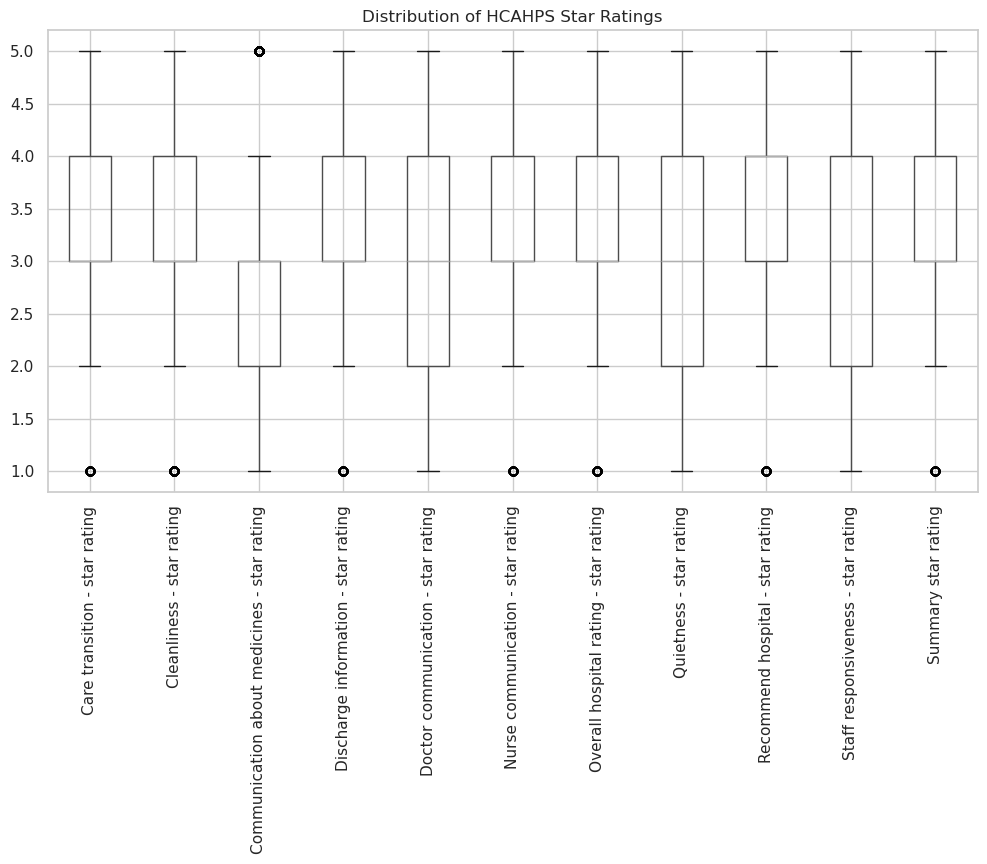

In [22]:
plt.figure(figsize=(12, 6))
df_clean[rating_cols].boxplot(rot=90)
plt.title('Distribution of HCAHPS Star Ratings')
plt.show()

## 7. Feature Selection
- Drop non-predictive identifiers
- Handle location features

In [23]:
id_cols = [
    'Facility ID',
    'Facility Name',
    'Address'
]

df_model = df_clean.drop(columns=id_cols)

In [25]:
df_model = df_model.drop(columns=[
    'City/Town',
    'County/Parish',
    'ZIP Code',
    'State'
])

State-level differences may reflect policy, funding, or regional healthcare variation. More granular geographic fields were excluded to reduce sparsity and overfitting.

In [26]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Care transition - star rating                3166 non-null   float64
 1   Cleanliness - star rating                    3166 non-null   float64
 2   Communication about medicines - star rating  3166 non-null   float64
 3   Discharge information - star rating          3166 non-null   float64
 4   Doctor communication - star rating           3166 non-null   float64
 5   Nurse communication - star rating            3166 non-null   float64
 6   Overall hospital rating - star rating        3166 non-null   float64
 7   Quietness - star rating                      3166 non-null   float64
 8   Recommend hospital - star rating             3166 non-null   float64
 9   Staff responsiveness - star rating           3166 non-null   float64
 10  

## 8. Correlation Analysis

In [27]:
corr = df_model.corr()

corr[target_col].sort_values(ascending=False)

HCAHPS Question
Overall hospital rating - star rating          1.000000
Recommend hospital - star rating               0.861984
Summary star rating                            0.840385
Nurse communication - star rating              0.792332
Care transition - star rating                  0.786144
Communication about medicines - star rating    0.734067
Doctor communication - star rating             0.733541
Staff responsiveness - star rating             0.726212
Discharge information - star rating            0.661661
Quietness - star rating                        0.614157
Cleanliness - star rating                      0.597297
Name: Overall hospital rating - star rating, dtype: float64

Features relating to communication appear to be most strongly associated with overall hospital ratings

## 9. Train-Test Split

Model type: regression

Test metrics: 
- RMSE
- R² 

In [32]:
X = df_model.drop(columns=['Overall hospital rating - star rating'])
y = df_model['Overall hospital rating - star rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.25, 
    random_state=42
)


print(X_train.shape, X_test.shape)

(1899, 10) (634, 10)


## 10. Feature Scaling

In [33]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The benefit of this step was debated as all features are already rated on the same scale (rated from 0 to 5) and would therefore contribute equally to the model. However, I ultimately concluded that scaling wouldn't hurt the model. It could still provide some benefit when an individual feature has small variance, as this can help balance the feature's influence with the other features in the dataset.

## 11. Baseline Model

Before building predictive models, I establish a baseline performance.

The baseline predicts the mean overall hospital rating for all hospitals. Success of the models is determined, in part, by outperforming this benchmark.

In [34]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)

y_val_pred = baseline.predict(X_val)

baseline_mae = mean_absolute_error(y_val, y_val_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
baseline_r2 = r2_score(y_val, y_val_pred)

print('Baseline MAE:', baseline_mae)
print('Baseline RMSE:', baseline_rmse)
print('Baseline R²:', baseline_r2)

Baseline MAE: 0.7975104549080875
Baseline RMSE: 0.958554952645663
Baseline R²: -0.0015236806757030763


## 12. Linear Regression Model

Linear regression serves as a simple and interpretable benchmark,
helping assess whether linear relationships explain patient satisfaction.

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_val_pred = lr.predict(X_val)

lr_mae = mean_absolute_error(y_val, y_val_pred)
lr_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
lr_r2 = r2_score(y_val, y_val_pred)

print('Linear Regression MAE:', lr_mae)
print('Linear Regression RMSE:', lr_rmse)
print('Linear Regression R²:', lr_r2)

Linear Regression MAE: 0.2959619641300384
Linear Regression RMSE: 0.3651367962061321
Linear Regression R²: 0.8546756487422537


Interpretation:
- The linear regression model outperforms the baseline
- Measures of error (MAE, RMSE) are lower than the baseline model
- A higher R² value indicates the model does a better job explaining the variance

Potential biases:
- A high R² value may indicate that the model performs well on training data, but may not perform well on test data. Further testing is needed.

## 13. Ridge Regression

To reduce overfitting and handle potential multicollinearity, I evaluate Ridge and Lasso regression.

In [38]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Ridge regression
ridge_preds = ridge.predict(X_val)
ridge_mae = mean_absolute_error(y_val, ridge_preds)
ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_preds))
ridge_r2 = r2_score(y_val, ridge_preds)

# Lasso regression
lasso_preds = lasso.predict(X_val)
lasso_mae = mean_absolute_error(y_val, lasso_preds)
lasso_rmse = np.sqrt(mean_squared_error(y_val, lasso_preds))
lasso_r2 = r2_score(y_val, lasso_preds)

print('Ridge R²:', ridge_r2)
print('Lasso R²:', lasso_r2)

Ridge R²: 0.8546810226745837
Lasso R²: 0.8535370033482186


## 14. Random Forest Regression

Tree-based models can capture nonlinear relationships and feature interactions
that linear models cannot.

In [39]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_val)

rf_mae = mean_absolute_error(y_val, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
rf_r2 = r2_score(y_val, rf_preds)

print('Random Forest MAE:', rf_mae)
print('Random Forest RMSE:', rf_rmse)
print('Random Forest R²:', rf_r2)

Random Forest MAE: 0.2542308287624659
Random Forest RMSE: 0.39067641858935176
Random Forest R²: 0.8336351444683796


## 15. Model Performance Comparison

Comparison of all models using validation-set performance.

In [40]:
results = pd.DataFrame({
    'Model': [
        'Baseline',
        'Linear Regression',
        'Ridge',
        'Lasso',
        'Random Forest'
    ],
    'MAE': [
        baseline_mae,
        lr_mae,
        ridge_mae,
        lasso_mae,
        rf_mae
    ],
    'RMSE': [
        baseline_rmse,
        lr_rmse,
        ridge_rmse,
        lasso_rmse,
        rf_rmse
    ],
    'R2': [
        baseline_r2,
        lr_r2,
        ridge_r2,
        lasso_r2,
        rf_r2
    ]
})

results.sort_values(by="RMSE")

,Model,MAE,RMSE,R2
2,Ridge,0.295980,0.365130,0.854681
1,Linear Regression,0.295962,0.365137,0.854676
3,Lasso,0.298697,0.366564,0.853537
4,Random Forest,0.254231,0.390676,0.833635
0,Baseline,0.797510,0.958555,-0.001524


An initial comparison indicates the ridge regression model performs best according to all values (MAE, RMSE, R²).

## 16. Feature Importance
Examine which survey dimensions most influence predicted hospital ratings.

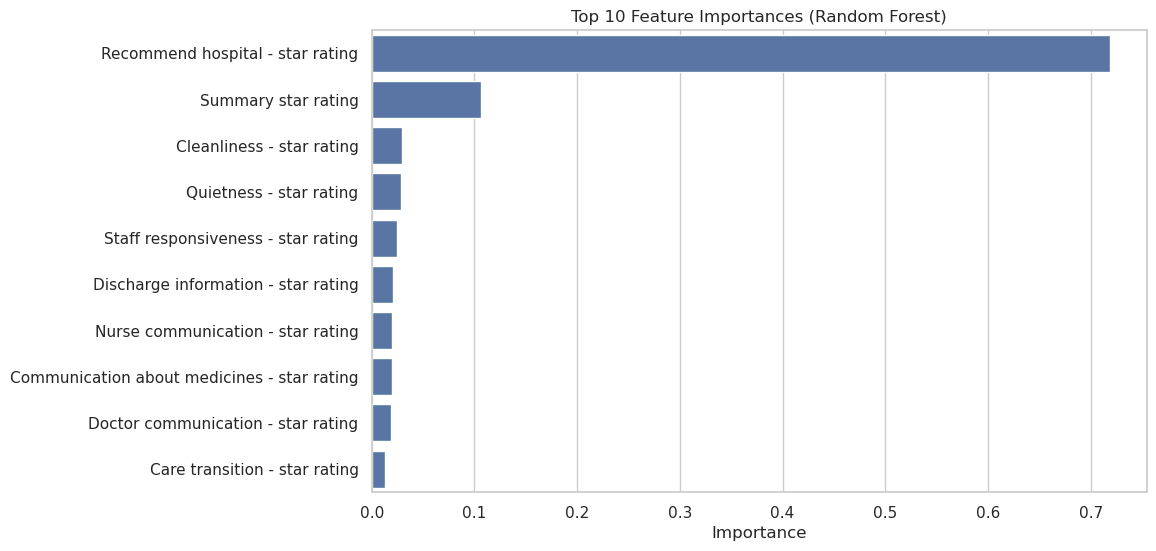

In [42]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances.head(10),
    y=importances.head(10).index
)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel("")
plt.show()

## 17. Final Model Evaluation on Test Set

In [41]:
y_test_pred = rf.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)
print('Test R²:', test_r2)

Test MAE: 0.24445543900003217
Test RMSE: 0.37914519956102444
Test R²: 0.835575370408533


## 18. Limitations and Future Work

- Overall star rating is ordinal but modeled as continuous
- Survey responses may contain bias
- External hospital characteristics are limited

Future enhancements include classification framing and hyperparameter tuning